## Characterizing Distinct CNC Machining Signals to Enhance Process Control

**Katherine Niemeyer** <br>
DTSA 5506: Data Mining Project <br>
University of Colorado - Boulder <br>


### Introduction & Problem Description:

Signal analysis is a large area of research in the manufacturing space, as connected data from processing tools is constantly transmitted to production databases. The challenge is to interpret these signals in real-time and leverage this information for process control. One area of production signal analysis is Computer Numerical Control (CNC) machining, where 3-dimensional accelerometers are attached to the machine spindle to transmit acceleration data as milling operations are performed. These acceleration signals are transferred to a database; however, quality auditors must still manually classify milled parts as good (OK) or bad (NOK).

**Goal:** <br>
Classify 15 unique CNC milling operations, and within each operation, distinguish between OK and NOK.

**Data:** <br>
From the UCI Machine Learning Repository, [Bosch CNC Machining Dataset](https://archive.ics.uci.edu/dataset/752/bosch+cnc+machining+dataset), published by Tnani et al [1].

*"The dataset provided is a collection of real-world industrial vibration data collected from a brownfield CNC milling machine. The acceleration has been measured using a tri-axial accelerometer (Bosch CISS Sensor) mounted inside the machine. The X- Y- and Z-axes of the accelerometer have been recorded using a sampling rate equal to 2 kHz. Thereby normal as well as anomoulous data have been collected for 6 different timeframes, each lasting 6 months from October 2018 until August 2021 and labelled accordingly. [...] In total there is data from three different CNC milling machines each executing 15 processes."*

### Exploratory Data Analysis



In [ ]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import itertools
from scipy import signal
from scipy import fft
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import seaborn as sns

In [ ]:
## Load data from GitHub repository

! git clone https://github.com/boschresearch/CNC_Machining.git

Cloning into 'CNC_Machining'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (593/593), done.
remote: Compressing objects: 100% (565/565), done.
remote: Total 1963 (delta 26), reused 581 (delta 19), pack-reused 1370
Receiving objects: 100% (1963/1963), 884.32 MiB | 33.14 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (1710/1710), done.


In [ ]:
## Get all files from dataset
## Note: Code in this chunk is based upon 'utils' in linked GitHub repo (CNC_Machining)


def find_all_h5s_in_dir(s_dir):
    """
    list all .h5 files in a directory
    """

    fileslist = []
    filepaths = []
    for root, dirs, files in os.walk(s_dir):
        for file in files:
            if file.endswith(".h5"):
                fileslist.append(file)
                filepaths.append(os.path.join(root, file))
    return fileslist, filepaths




## Load data

def load_tool_research_data(data_path, label, add_additional_label=True, verbose=True):
    """
    load data (good and bad) from the research data storages

    Keyword Arguments:
            data_path {str} -- [path to the directory]
            label {str} -- ["good" or "bad"]
            add_additional_label {bool} -- [if true the labels will be in the form of "Mxx_Aug20xx_OPxx_sampleNr_label" otherwise "label"] (default: True)
            verbose {bool}

        Returns:
            datalist --  [list of the the X samples]
            label --  [list of the the y labels ]
    """
    datalist = []
    data_label = []

    # list all .h5 files
    list_files, list_paths = find_all_h5s_in_dir(data_path)
    list_paths.sort()

    ## subset list paths to good or bad, depending on label arg
    paths_subset = [k for k in list_paths if label in k]

    # read and append the samples with the corresponding labels
    if verbose:
        print(f"loading files from {data_path}... ")
    for element in paths_subset:
        # check if additional label needed ("Mxx_Aug20xx_Tool,nrX")
        if add_additional_label:
            add_label = element.split('/')[-1]
            additional_label = add_label[:-3] + "_" + label
        else:
            additional_label = label
        # extract data X and y
        with h5py.File(os.path.join(data_path, element), 'r') as f:
            vibration_data = f['vibration_data'][:]
        datalist.append(vibration_data)
        data_label.append(additional_label)

    return datalist, data_label



def datafile_read(file, plotting=True):
    """loads and plots the data from the datafile

    Keyword Arguments:
        file {str} -- [path of the file]

    Returns:
        ndarray --  [raw data original]
    """
    with h5py.File(file, 'r') as f:
        vibration_data = f['vibration_data'][:]
    # interpolation for x axis plot
    freq = 2000
    samples_s = len(vibration_data[:, 0]) / freq
    samples = np.linspace(0, samples_s, len(vibration_data[:, 0]))

    # plotting
    if plotting:
        plt.figure(figsize=(20, 5))
        plt.plot(samples, vibration_data[:, 0], 'b')
        plt.ylabel('X-axis Vibration Data')
        plt.xlabel('Time [sec]')
        plt.locator_params(axis='y', nbins=10)
        plt.grid()
        plt.show()
        plt.figure(figsize=(20, 5))
        plt.plot(samples, vibration_data[:, 1], 'b')
        plt.ylabel('Y-axis Vibration Data')
        plt.xlabel('Time [sec]')
        plt.locator_params(axis='y', nbins=10)
        plt.grid()
        plt.show()
        plt.figure(figsize=(20, 5))
        plt.plot(samples, vibration_data[:, 2], 'b')
        plt.ylabel('Z-axis Vibration Data')
        plt.xlabel('Time [sec]')
        plt.locator_params(axis='y', nbins=10)
        plt.grid()
        plt.show()
    return vibration_data

In [ ]:
s_dir = '/content/CNC_Machining/data'


## Load data
good_datalist, good_datalabel = load_tool_research_data(s_dir, "good", add_additional_label=True, verbose=True)
bad_datalist, bad_datalabel = load_tool_research_data(s_dir, "bad", add_additional_label=True, verbose=True)

loading files from /content/CNC_Machining/data... 
loading files from /content/CNC_Machining/data... 


In [ ]:
## Load a list of all file paths to access later

# all_files, all_paths = find_all_h5s_in_dir(s_dir)

In [ ]:
# print(bad_datalist[0].shape)
# print(bad_datalabel[0])
# print(bad_datalist[0][0].shape)

In [ ]:
## View example trace
# datafile_read(all_paths[0])

In [ ]:
# all parameters

machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]

In [ ]:
### Explore sample of M01 OP02 data

m01_op2_good_array, m01_op2_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              process_names[2],
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP02/good... 


In [ ]:
m01_op2_good_array[0][:,0]

## Check out min and max accelerations
mins = [[],[],[]]
maxes = [[],[],[]]
lens = [[],[],[]]
for channel in range(3):
  for sample in range(len(m01_op2_good_array)):
    mins[channel].append(np.min(m01_op2_good_array[sample][:,channel]))
    maxes[channel].append(np.max(m01_op2_good_array[sample][:,channel]))
    lens[channel].append(len(m01_op2_good_array[sample][:,channel]))

In [ ]:
len(m01_op2_good_array[2][:,0])

89088

(array([ 2.,  2., 15., 11.,  3.,  4.,  1.,  6.,  0.,  1.]),
 array([83968. , 85401.6, 86835.2, 88268.8, 89702.4, 91136. , 92569.6,
        94003.2, 95436.8, 96870.4, 98304. ]),
 <BarContainer object of 10 artists>)

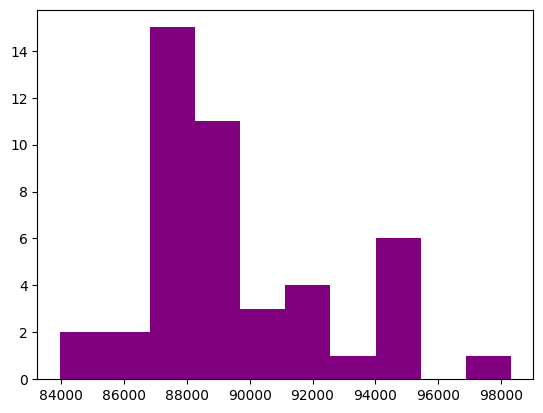

In [ ]:
plt.hist(lens[0], color = 'blue')
plt.hist(lens[1], color = 'green')
plt.hist(lens[2], color = 'purple')

(array([2., 4., 1., 5., 4., 7., 5., 4., 9., 4.]),
 array([-2012. , -1977.3, -1942.6, -1907.9, -1873.2, -1838.5, -1803.8,
        -1769.1, -1734.4, -1699.7, -1665. ]),
 <BarContainer object of 10 artists>)

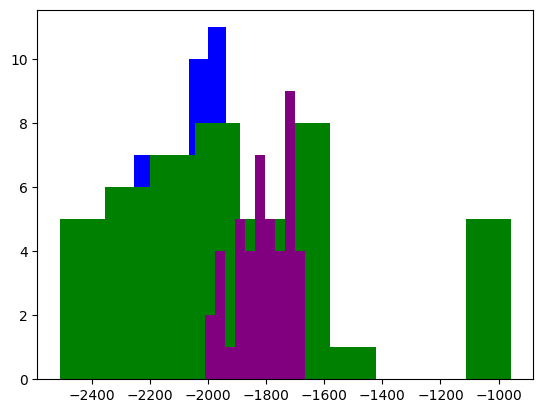

In [ ]:
plt.hist(mins[0], color = 'blue')
plt.hist(mins[1], color = 'green', stacked = True)
plt.hist(mins[2], color = 'purple', stacked = True)

(array([ 8., 10.,  3.,  9.,  4.,  2.,  7.,  1.,  0.,  1.]),
 array([-359. , -300.5, -242. , -183.5, -125. ,  -66.5,   -8. ,   50.5,
         109. ,  167.5,  226. ]),
 <BarContainer object of 10 artists>)

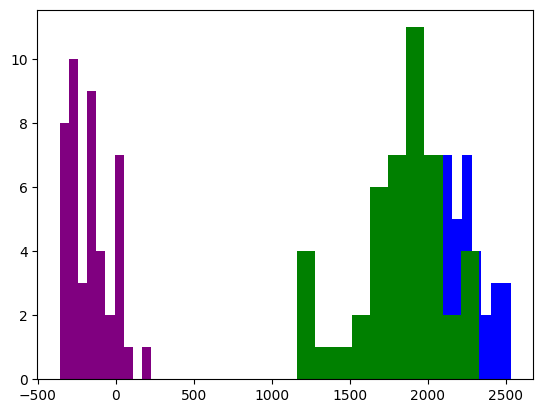

In [ ]:
plt.hist(maxes[0], color = 'blue')
plt.hist(maxes[1], color = 'green', stacked = True)
plt.hist(maxes[2], color = 'purple', stacked = True)

It looks like the z-axis may have the least amount of variation and so would be good to focus the analysis on.

Let's try FFT on a sample z-axis signature to check out the frequencies. Also check out a 3D FFT to see how that differs.

Text(0.5, 1.0, 'Example FFT on Z-Axis Data')

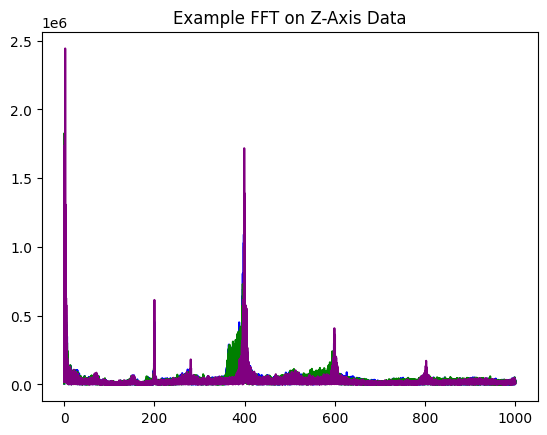

In [ ]:
## First 3 entries for z axis
sample1 = m01_op2_good_array[0][:,2]
sample2 = m01_op2_good_array[1][:,2]
sample3 = m01_op2_good_array[2][:,2]

## Lengths of each dataset
n1 = len(sample1)
n2 = len(sample2)
n3 = len(sample3)

## 2 kHz sampling frequency
timestep = 1/2000  # 2 kHz, 2000 samples per second

## Compute FFTs
sample_fft1 = fft.fft(sample1)
sample_freq1 = fft.fftfreq(n1, timestep)

sample_fft2 = fft.fft(sample2)
sample_freq2 = fft.fftfreq(n2, timestep)

sample_fft3 = fft.fft(sample3)
sample_freq3 = fft.fftfreq(n3, timestep)


## Plot each on same graph
plt.plot(sample_freq1[1:n1//2], np.abs(sample_fft1[1:n1//2]), color = 'blue')
plt.plot(sample_freq2[1:n2//2], np.abs(sample_fft2[1:n2//2]), color = 'green')
plt.plot(sample_freq3[1:n3//2], np.abs(sample_fft3[1:n3//2]), color = 'purple')
plt.title('Example FFT on Z-Axis Data')

## Maybe easier to make faceted

In [ ]:
np.where(sample_freq1[1:n1//2] < 10)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

M01_Aug_2019_OP02_000_good


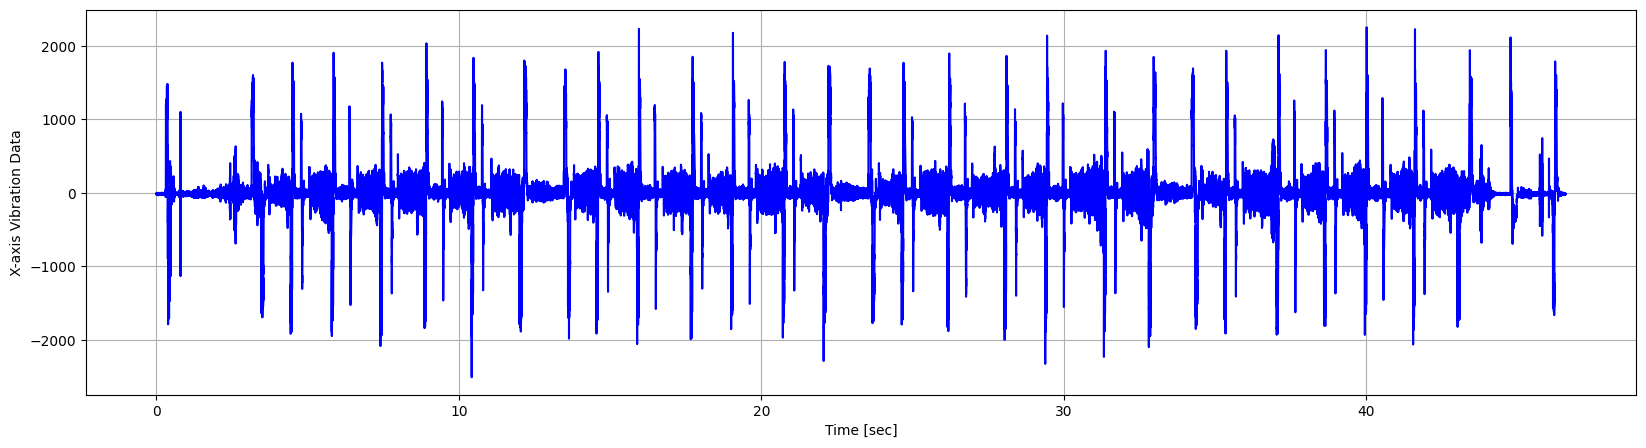

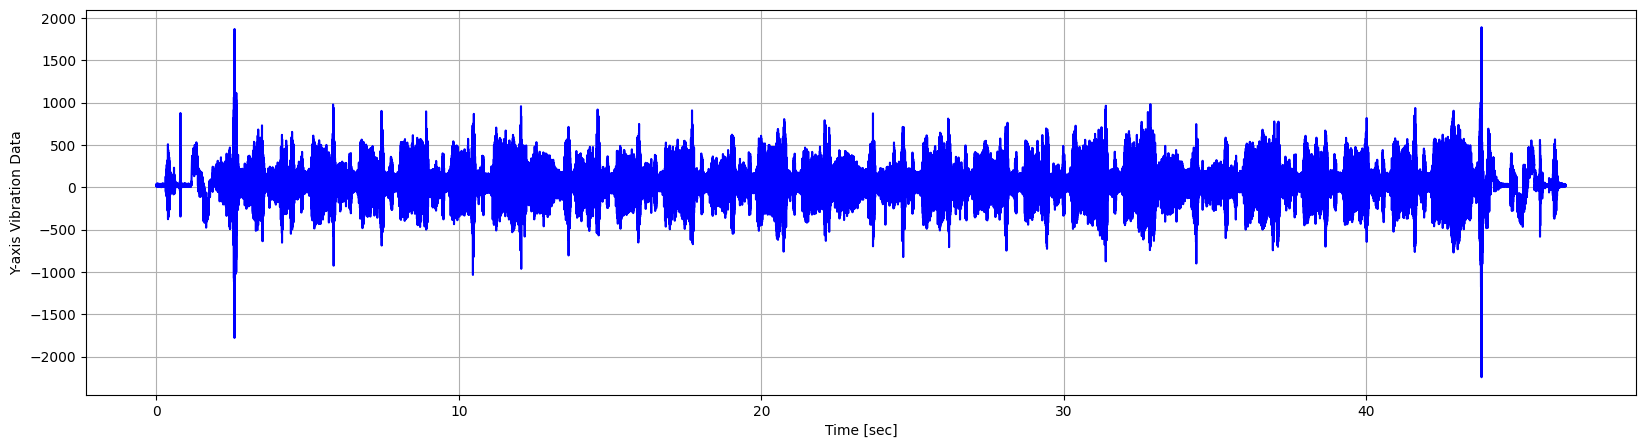

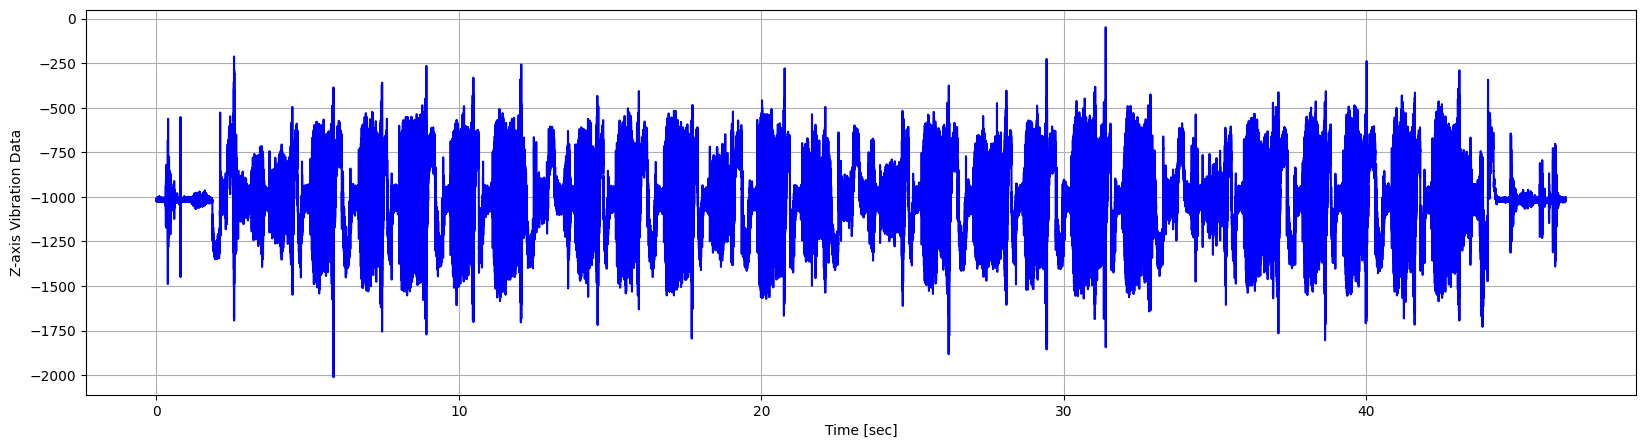

array([[   -9.,    13., -1018.],
       [  -25.,    17., -1018.],
       [  -13.,    15., -1022.],
       ...,
       [  -15.,     9., -1020.],
       [  -21.,    23., -1015.],
       [  -13.,    25., -1001.]])

In [ ]:
## Recall what total signature looked like:
print(m01_op2_good_paths[0])

datafile_read(os.path.join(s_dir, 'M01', 'OP02', 'good', 'M01_Aug_2019_OP02_000.h5'))

I am going to need to clip / window the signal because it looks like there are ramp up & ramp down steps.

From the FFT plot of the 3 z-axis signals, it looks like the primary signal is being produced from frequencies 200, 400 and 600 Hz. I am going to apply a band-pass filter to reduce the signal to this frequency range, then re-plot the signal to see if it is cleaner.

In [ ]:
## Source: https://swharden.com/blog/2020-09-23-signal-filtering-in-python/

## Adapted function slightly

# def bandpass(data: np.ndarray, freq_range: list[float], sample_rate = 2000, poles: int = 5):
#     sos = signal.butter(poles, freq_range, 'bandpass', fs=sample_rate, output='sos')
#     filtered_data = signal.sosfiltfilt(sos, data)
#     return filtered_data

# filtered1 = bandpass(data = sample1, freq_range = [200, 600])

## Try filtering out anything above 600

def lowpass(data: np.ndarray, freq_max: float, sample_rate = 2000, poles: int = 5):
    sos = signal.butter(poles, freq_max, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data




# filtered1_band = bandpass(data = sample1, freq_range = [200, 400])


In [ ]:
# plt.plot(np.arange(len(sample1))/2000, filtered1_band)

Text(0, 0.5, 'X-axis Vibration Data')

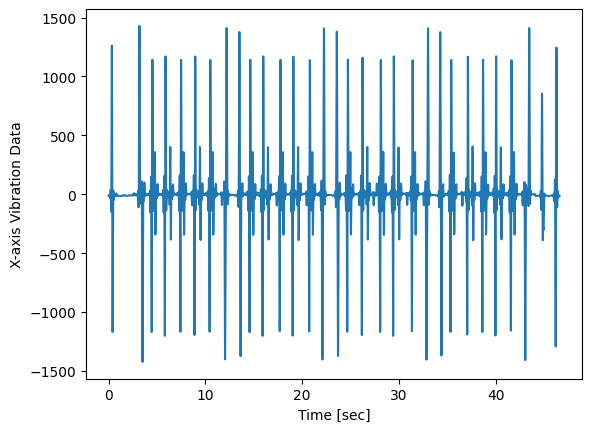

In [ ]:
op2_sample = m01_op2_good_array[0][:,0]

filtered2_low = lowpass(data = op2_sample, freq_max = 10)
#plt.axes(aspect = 0.15)
plt.plot(np.arange(len(op2_sample))/2000, filtered2_low)
plt.xlabel('Time [sec]')
plt.ylabel('X-axis Vibration Data')


Text(0, 0.5, 'X-axis Vibration Data')

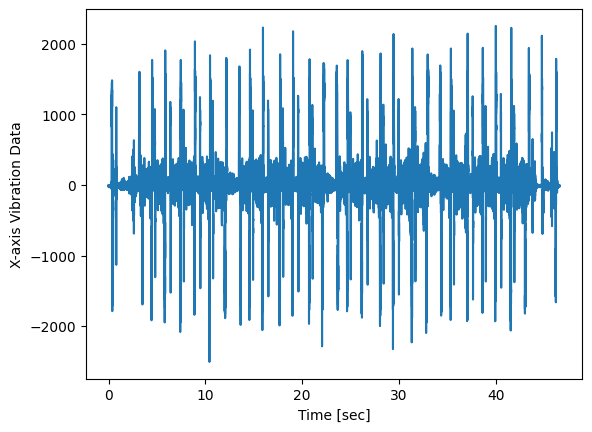

In [ ]:
plt.plot(np.arange(len(op2_sample))/2000, op2_sample)
plt.xlabel('Time [sec]')
plt.ylabel('X-axis Vibration Data')

Now the the signal is cleaned, I can see that there are repeat units within the signal. It looks like there are 5 roughly equivalent peaks flanked by two higher peaks.

Based on the repeat unit, I would like to trim the signals to a region that includes one period. I'd like to skip the first peak because that will help trim the initial ramp-up region.

In [ ]:
## Find peaks on cleaned signal

peaks_indices, peak_props = signal.find_peaks(x = filtered2_low,
                                              prominence = 1000)


In [ ]:
peaks_indices

array([  679,  6372,  8777,  9055, 11771, 14982, 17906, 21021, 24393,
       27030, 29001, 29280, 31964, 35512, 38180, 41600, 44510, 47162,
       49180, 49460, 52480, 56266, 58950, 62832, 66014, 68539, 70524,
       70805, 74255, 77387, 80087, 83281, 86924, 92549])

In [ ]:
peak_proms = signal.peak_prominences(filtered2_low, peaks_indices)

In [ ]:
peak_proms

(array([1408.53626661, 2597.61093547, 1318.01567077, 2342.98054631,
        2570.83122384, 2307.21483265, 2363.00691004, 2306.41809492,
        2818.0997874 , 1484.83053793, 1321.95407005, 2343.82826814,
        2543.79288892, 2302.82646816, 2367.22321348, 2301.78953484,
        2811.31641065, 1489.70407807, 1329.11598259, 2338.16298483,
        2360.91882987, 2309.60437608, 2543.01373274, 2298.4274654 ,
        2812.76087789, 1486.84363915, 1333.22681113, 2330.11884901,
        2365.509829  , 2310.81646338, 2539.63160778, 2294.52856775,
        2702.55306927, 1354.91173642]),
 array([  533,   829,  7011,  7011,  7011, 14838, 17762, 20878,  7011,
        26856, 27281, 27281, 27281, 35368, 38037, 41456, 44186, 46988,
        47414, 47414, 47414, 56123, 47414, 62688, 65690, 68364, 68790,
        68790, 68790, 77243, 68790, 83138,  7011, 92396]),
 array([  829,  7011,  8912, 11628, 24070, 17762, 24070, 24070, 86109,
        44186, 29137, 31821, 44186, 38037, 44186, 44186, 65690, 65690,
  

Text(0, 0.5, 'X-axis Vibration Data')

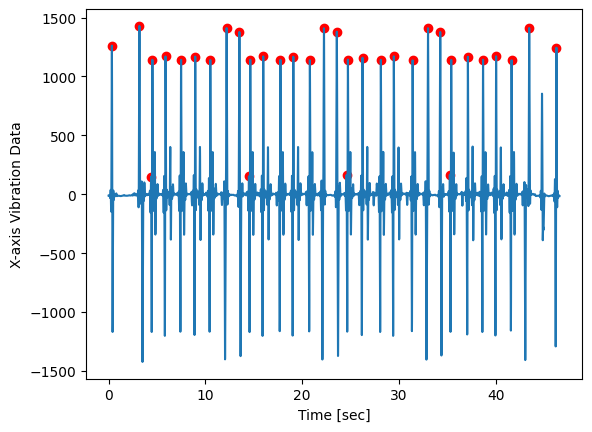

In [ ]:
x_times_op2 = np.arange(len(filtered2_low))/2000

plt.plot(x_times_op2, filtered2_low)
plt.scatter(x_times_op2[peaks_indices], filtered2_low[peaks_indices], color = 'red')
plt.xlabel('Time [sec]')
plt.ylabel('X-axis Vibration Data')

In [ ]:
(peaks_indices[0] + peaks_indices[1])//2

3525

In [ ]:
# Iterate through the peaks and keep only the first 6 indices of each repeat unit
# I don't want the first peak, trim out the beginning
# I want the second peak through the index right before the 8th peak
trimmed_indices = np.arange(start = (peaks_indices[0] + peaks_indices[1])//2, # between 1st and 2nd
                            stop = (peaks_indices[8] + peaks_indices[9])//2)


# Trim the signal based on the selected indices
trimmed_signal = filtered2_low[trimmed_indices]

Text(0.5, 1.0, 'Cleaned Signal - OP02')

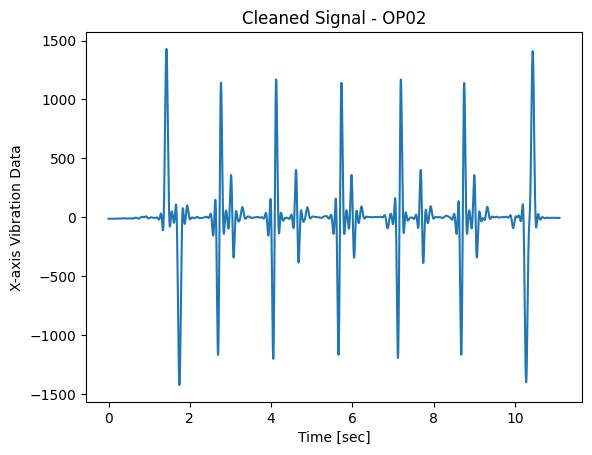

In [ ]:
plt.plot(np.arange(len(trimmed_signal))/2000, trimmed_signal)
plt.xlabel('Time [sec]')
plt.ylabel('X-axis Vibration Data')
plt.title('Cleaned Signal - OP02')

## Looks great!

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP02')

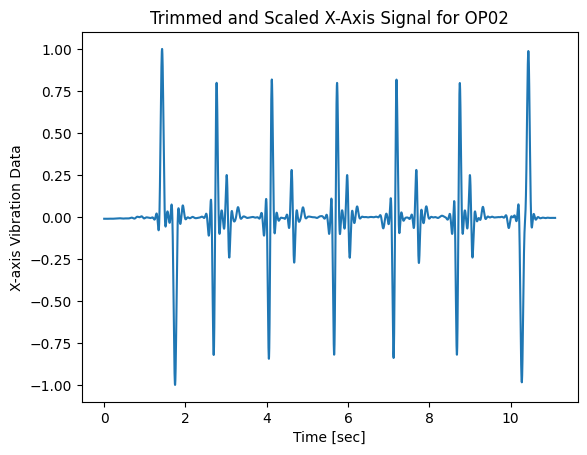

In [ ]:
## Now scale the signal to -1 to 1 using minmaxscaler

scaler = MinMaxScaler((-1, 1))

trimmed_scaled = scaler.fit_transform(trimmed_signal.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal))/2000, trimmed_scaled)
plt.xlabel('Time [sec]')
plt.ylabel('X-axis Vibration Data')
plt.title('Trimmed and Scaled X-Axis Signal for OP02')

### Repeat Cleaning for Other OPs

The steps above were:
1. Applied a low pass filter to a sample signal's x-axis trace.
2. Found repeat unit within signal
3. Used peak indices and prominences with a threshold to trim signal to one repeat unit.
4. Normalize array to -1 to 1.

### Operation 00

In [ ]:
### OP00

m01_op0_good_array, m01_op0_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP00',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP00/good... 


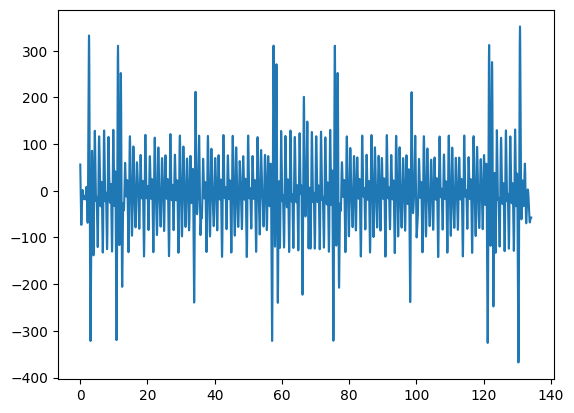

In [ ]:
## get x-axis signal

op0_sample = m01_op0_good_array[0][:,0]

filtered_op0 = lowpass(data = op0_sample, freq_max = 1.5)

plt.plot(np.arange(len(op0_sample))/2000, filtered_op0)

This repeat unit is a little different, and instead looks like an 'H' with a smaller peak in between the 'H' units.

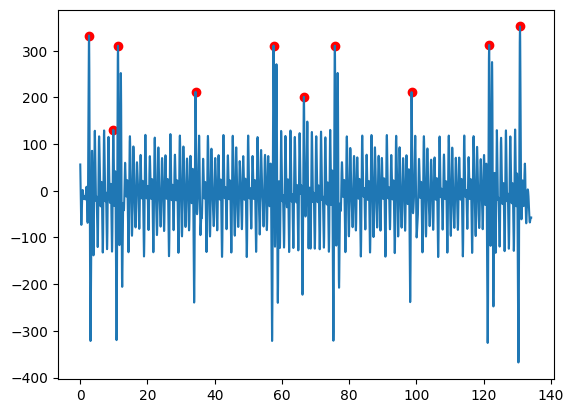

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op0, peak_props_op0 = signal.find_peaks(x = filtered_op0,
                                              prominence = 400)

## Get peak prominences
peak_proms_op0 = signal.peak_prominences(filtered_op0, peaks_indices_op0)

## Plot filtered peaks against signal
x_times_op0 = np.arange(len(filtered_op0))/2000

plt.plot(x_times_op0, filtered_op0)
plt.scatter(x_times_op0[peaks_indices_op0],
            filtered_op0[peaks_indices_op0],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP00')

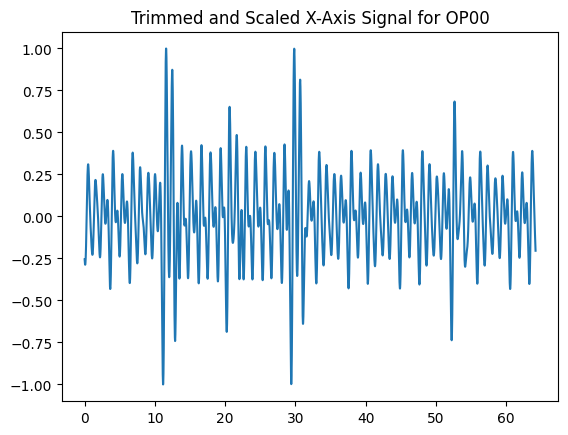

In [ ]:
## Now we want to trim from halfway between peaks 4 and 5 to half between 8 and 9

trimmed_indices_op0 = np.arange(start = (peaks_indices_op0[3] + peaks_indices_op0[4])//2, # between 1st and 2nd
                            stop = (peaks_indices_op0[7] + peaks_indices_op0[8])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op0 = filtered_op0[trimmed_indices_op0]

# Rescale signal
trimmed_scaled_op0 = scaler.fit_transform(trimmed_signal_op0.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op0))/2000, trimmed_scaled_op0)
plt.title('Trimmed and Scaled X-Axis Signal for OP00')


### Operation 01

In [ ]:
### Next OP: OP01

m01_op1_good_array, m01_op1_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP01',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP01/good... 


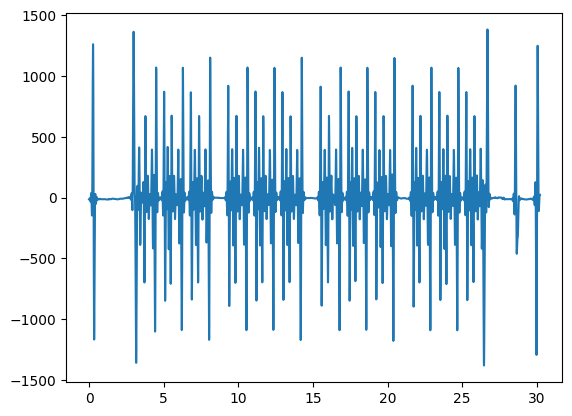

In [ ]:
## get x-axis signal

op1_sample = m01_op1_good_array[0][:,0]

filtered_op1 = lowpass(data = op1_sample, freq_max = 10)

plt.plot(np.arange(len(op1_sample))/2000, filtered_op1)

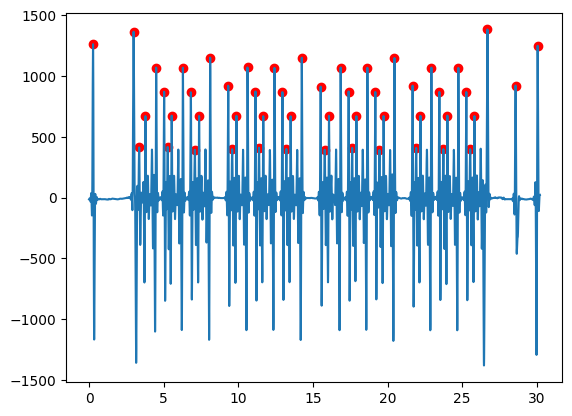

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op1, peak_props_op1 = signal.find_peaks(x = filtered_op1,
                                              prominence = 1000)

## Get peak prominences
peak_proms_op1 = signal.peak_prominences(filtered_op1, peaks_indices_op1)

## Plot filtered peaks against signal
x_times_op1 = np.arange(len(filtered_op1))/2000

plt.plot(x_times_op1, filtered_op1)
plt.scatter(x_times_op1[peaks_indices_op1],
            filtered_op1[peaks_indices_op1],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP01')

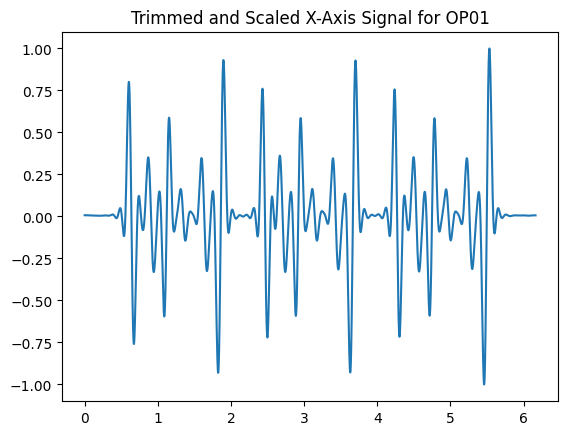

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op1 = np.arange(start = (peaks_indices_op1[12] + peaks_indices_op1[13])//2, # between 1st and 2nd
                            stop = (peaks_indices_op1[24] + peaks_indices_op1[25])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op1 = filtered_op1[trimmed_indices_op1]

# Rescale signal
trimmed_scaled_op1 = scaler.fit_transform(trimmed_signal_op1.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op1))/2000, trimmed_scaled_op1)
plt.title('Trimmed and Scaled X-Axis Signal for OP01')

### Operation 03

In [ ]:
### Next OP: OP03

m01_op3_good_array, m01_op3_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP03',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP03/good... 


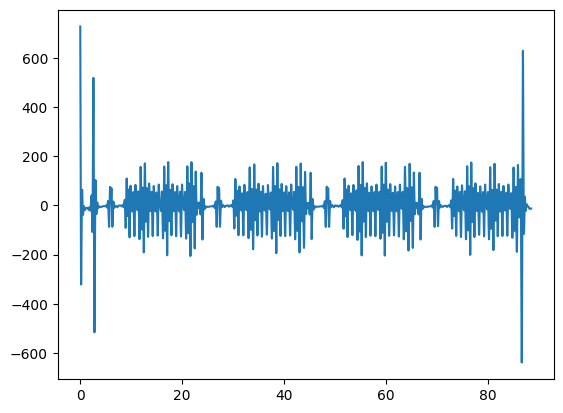

In [ ]:
## get x-axis signal

op3_sample = m01_op3_good_array[0][:,0]

filtered_op3 = lowpass(data = op3_sample, freq_max = 3)

plt.plot(np.arange(len(op3_sample))/2000, filtered_op3)

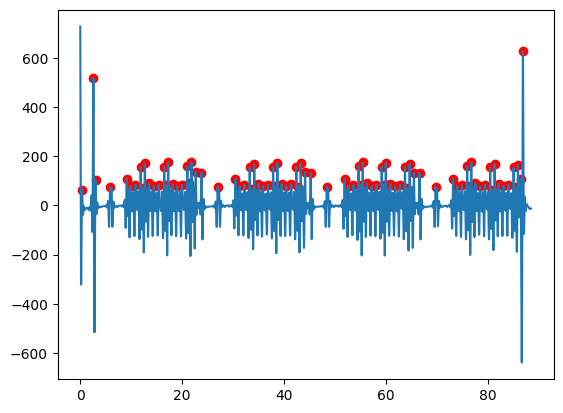

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op3, peak_props_op3 = signal.find_peaks(x = filtered_op3,
                                              prominence = 150)

## Get peak prominences
peak_proms_op3 = signal.peak_prominences(filtered_op3, peaks_indices_op3)

## Plot filtered peaks against signal
x_times_op3 = np.arange(len(filtered_op3))/2000

plt.plot(x_times_op3, filtered_op3)
plt.scatter(x_times_op3[peaks_indices_op3],
            filtered_op3[peaks_indices_op3],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP03')

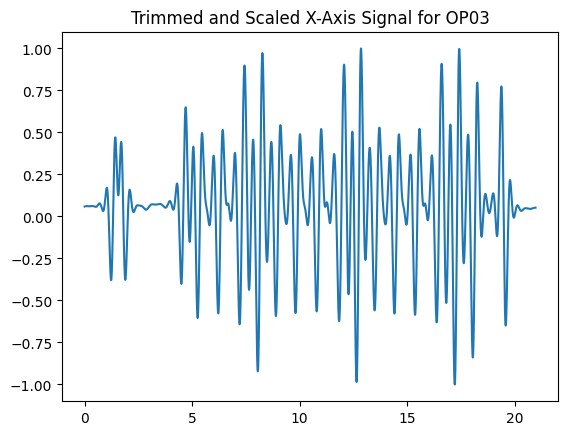

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op3 = np.arange(start = (peaks_indices_op3[2] + peaks_indices_op3[3])//2, # between 1st and 2nd
                            stop = (peaks_indices_op3[23] + peaks_indices_op3[24])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op3 = filtered_op3[trimmed_indices_op3]

# Rescale signal
trimmed_scaled_op3 = scaler.fit_transform(trimmed_signal_op3.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op3))/2000, trimmed_scaled_op3)
plt.title('Trimmed and Scaled X-Axis Signal for OP03')

### Operation 04

In [ ]:
### Next OP: OP04

m01_op4_good_array, m01_op4_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP04',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP04/good... 


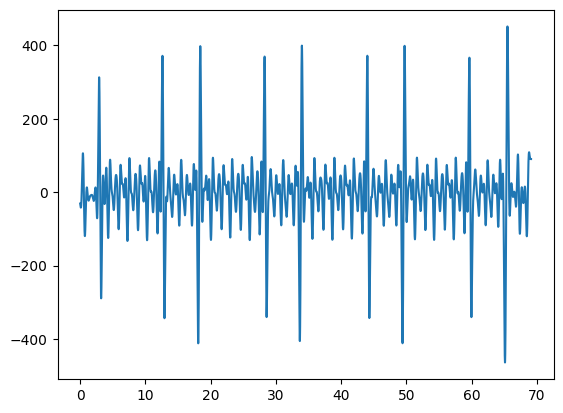

In [ ]:
## get x-axis signal

op4_sample = m01_op4_good_array[0][:,0]

filtered_op4 = lowpass(data = op4_sample, freq_max = 2)

plt.plot(np.arange(len(op4_sample))/2000, filtered_op4)

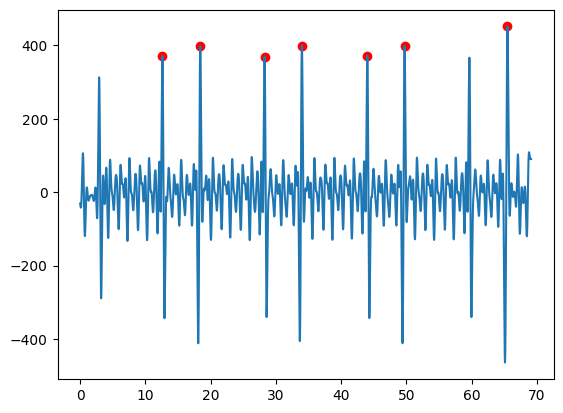

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op4, peak_props_op4 = signal.find_peaks(x = filtered_op4,
                                              prominence = 500)

## Get peak prominences
peak_proms_op4 = signal.peak_prominences(filtered_op4, peaks_indices_op4)

## Plot filtered peaks against signal
x_times_op4 = np.arange(len(filtered_op4))/2000

plt.plot(x_times_op4, filtered_op4)
plt.scatter(x_times_op4[peaks_indices_op4],
            filtered_op4[peaks_indices_op4],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP04')

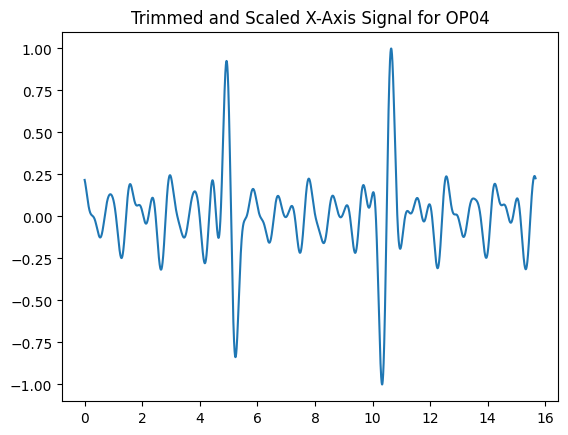

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op4 = np.arange(start = (peaks_indices_op4[1] + peaks_indices_op4[2])//2, # between 1st and 2nd
                            stop = (peaks_indices_op4[3] + peaks_indices_op4[4])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op4 = filtered_op4[trimmed_indices_op4]

# Rescale signal
trimmed_scaled_op4 = scaler.fit_transform(trimmed_signal_op4.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op4))/2000, trimmed_scaled_op4)
plt.title('Trimmed and Scaled X-Axis Signal for OP04')

### Operation 05

In [ ]:
### Next OP: OP05

m01_op5_good_array, m01_op5_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP05',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP05/good... 


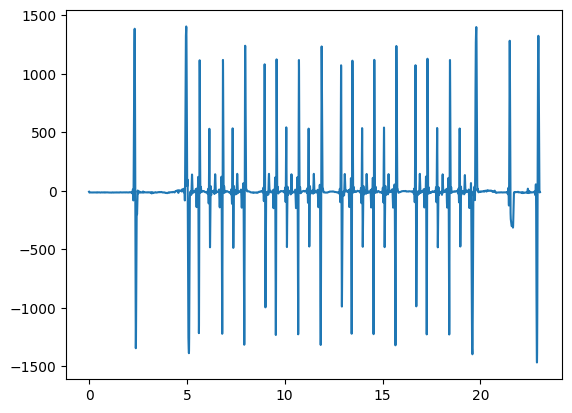

In [ ]:
## get x-axis signal

op5_sample = m01_op5_good_array[0][:,0]

filtered_op5 = lowpass(data = op5_sample, freq_max = 20)

plt.plot(np.arange(len(op5_sample))/2000, filtered_op5)

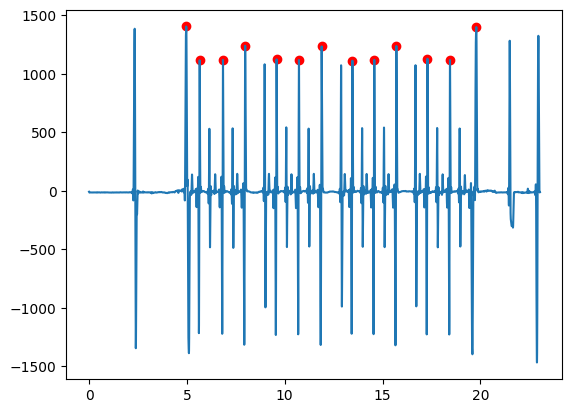

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op5, peak_props_op5 = signal.find_peaks(x = filtered_op5,
                                              prominence = 1500)

## Get peak prominences
peak_proms_op5 = signal.peak_prominences(filtered_op5, peaks_indices_op5)

## Plot filtered peaks against signal
x_times_op5 = np.arange(len(filtered_op5))/2000

plt.plot(x_times_op5, filtered_op5)
plt.scatter(x_times_op5[peaks_indices_op5],
            filtered_op5[peaks_indices_op5],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP05')

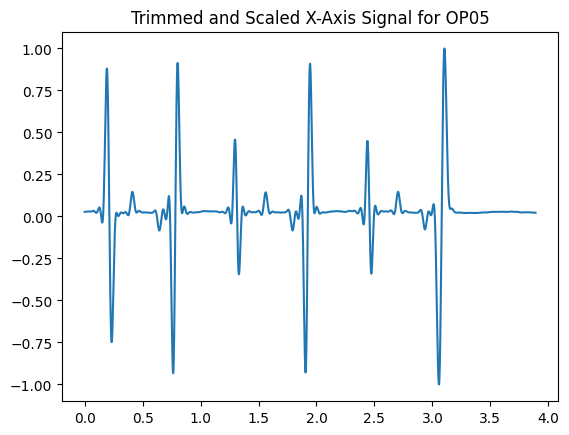

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op5 = np.arange(start = (peaks_indices_op5[3] + peaks_indices_op5[4])//2, # between 1st and 2nd
                            stop = (peaks_indices_op5[6] + peaks_indices_op5[7])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op5 = filtered_op5[trimmed_indices_op5]

# Rescale signal
trimmed_scaled_op5 = scaler.fit_transform(trimmed_signal_op5.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op5))/2000, trimmed_scaled_op5)
plt.title('Trimmed and Scaled X-Axis Signal for OP05')

### Operation 6

In [ ]:
### Next OP: OP06

m01_op6_good_array, m01_op6_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP06',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP06/good... 


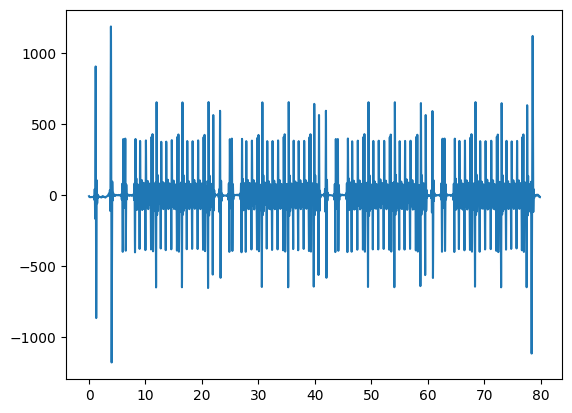

In [ ]:
## get x-axis signal

op6_sample = m01_op6_good_array[0][:,0]

filtered_op6 = lowpass(data = op6_sample, freq_max = 7)

plt.plot(np.arange(len(op6_sample))/2000, filtered_op6)

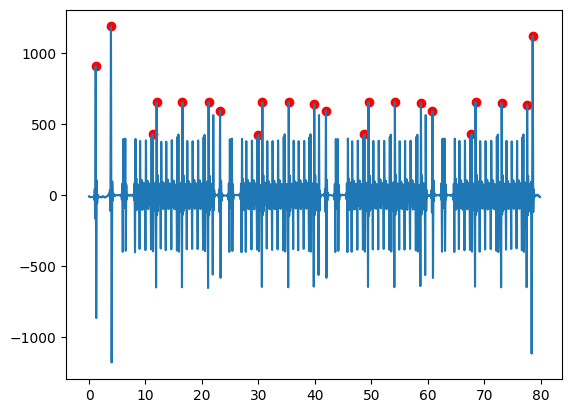

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op6, peak_props_op6 = signal.find_peaks(x = filtered_op6,
                                              prominence = 1000)

## Get peak prominences
peak_proms_op6 = signal.peak_prominences(filtered_op6, peaks_indices_op6)

## Plot filtered peaks against signal
x_times_op6 = np.arange(len(filtered_op6))/2000

plt.plot(x_times_op6, filtered_op6)
plt.scatter(x_times_op6[peaks_indices_op6],
            filtered_op6[peaks_indices_op6],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP06')

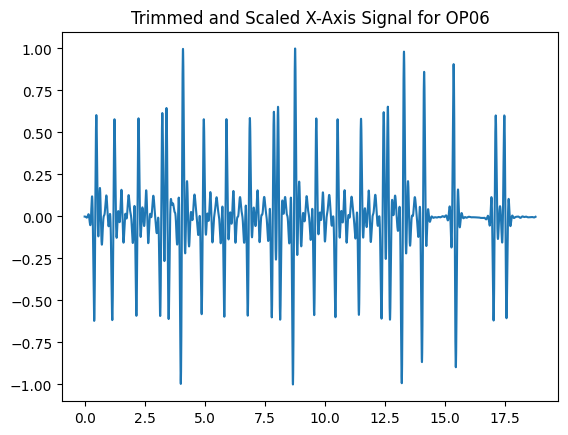

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op6 = np.arange(start = (peaks_indices_op6[6] + peaks_indices_op6[7])//2, # between 1st and 2nd
                            stop = (peaks_indices_op6[11] + peaks_indices_op6[12])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op6 = filtered_op6[trimmed_indices_op6]

# Rescale signal
trimmed_scaled_op6 = scaler.fit_transform(trimmed_signal_op6.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op6))/2000, trimmed_scaled_op6)
plt.title('Trimmed and Scaled X-Axis Signal for OP06')

### Operation 9 (Straight Flute)

In [ ]:
### Next OP: OP09

m01_op9_good_array, m01_op9_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP09',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP09/good... 


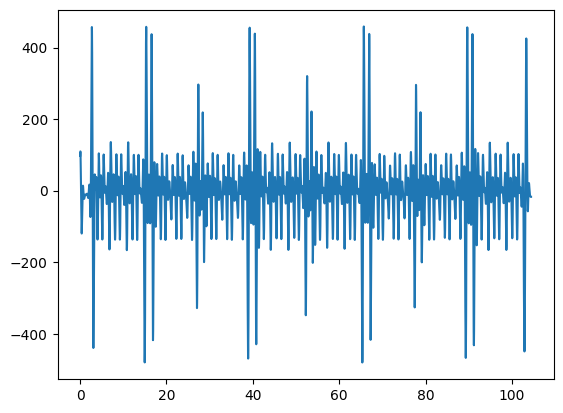

In [ ]:
## get x-axis signal

op9_sample = m01_op9_good_array[0][:,0]

filtered_op9 = lowpass(data = op9_sample, freq_max = 2)

plt.plot(np.arange(len(op9_sample))/2000, filtered_op9)

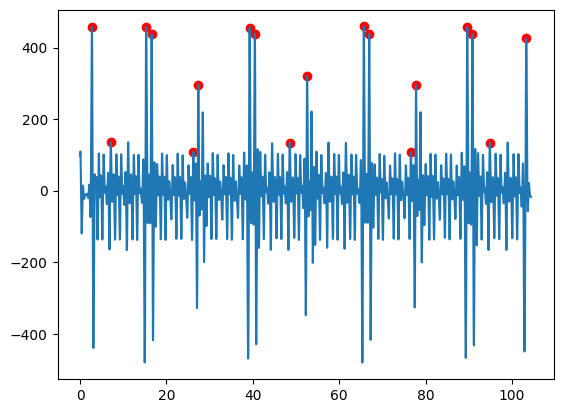

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op9, peak_props_op9 = signal.find_peaks(x = filtered_op9,
                                              prominence = 400)

## Get peak prominences
peak_proms_op9 = signal.peak_prominences(filtered_op9, peaks_indices_op9)

## Plot filtered peaks against signal
x_times_op9 = np.arange(len(filtered_op9))/2000

plt.plot(x_times_op9, filtered_op9)
plt.scatter(x_times_op9[peaks_indices_op9],
            filtered_op9[peaks_indices_op9],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP09')

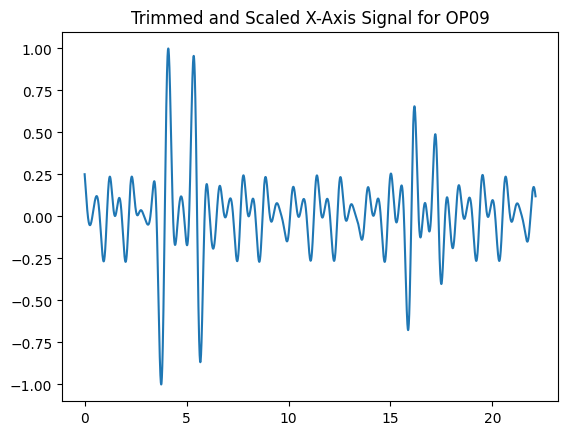

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op9 = np.arange(start = (peaks_indices_op9[1] + peaks_indices_op9[2])//2, # between 1st and 2nd
                            stop = (peaks_indices_op9[5] + peaks_indices_op9[6])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op9 = filtered_op9[trimmed_indices_op9]

# Rescale signal
trimmed_scaled_op9 = scaler.fit_transform(trimmed_signal_op9.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op9))/2000, trimmed_scaled_op9)
plt.title('Trimmed and Scaled X-Axis Signal for OP09')

### Operation 13 (T-Slot Cutter)

In [ ]:
### Next OP: OP13

m01_op13_good_array, m01_op13_good_paths = load_tool_research_data(os.path.join(s_dir,
                                                                              machines[0],
                                                                              'OP13',
                                                                              labels[0]),
                                       'good')

loading files from /content/CNC_Machining/data/M01/OP13/good... 


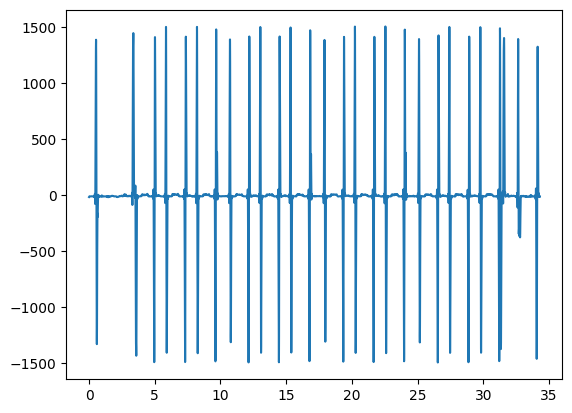

In [ ]:
## get x-axis signal

op13_sample = m01_op13_good_array[0][:,0]

filtered_op13 = lowpass(data = op13_sample, freq_max = 20)

plt.plot(np.arange(len(op13_sample))/2000, filtered_op13)

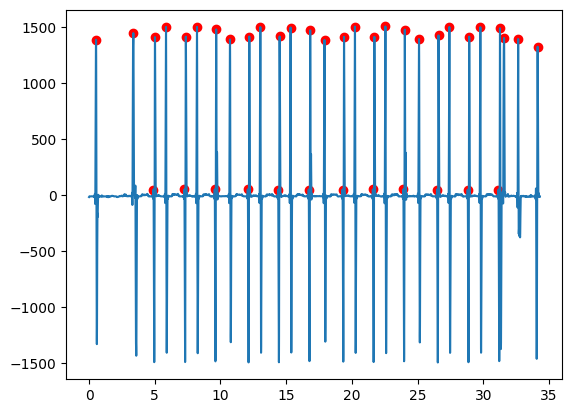

In [ ]:
## Find peaks on cleaned signal
peaks_indices_op13, peak_props_op13 = signal.find_peaks(x = filtered_op13,
                                              prominence = 1000)

## Get peak prominences
peak_proms_op13 = signal.peak_prominences(filtered_op13, peaks_indices_op13)

## Plot filtered peaks against signal
x_times_op13 = np.arange(len(filtered_op13))/2000

plt.plot(x_times_op13, filtered_op13)
plt.scatter(x_times_op13[peaks_indices_op13],
            filtered_op13[peaks_indices_op13],
            color = 'red')

Text(0.5, 1.0, 'Trimmed and Scaled X-Axis Signal for OP13')

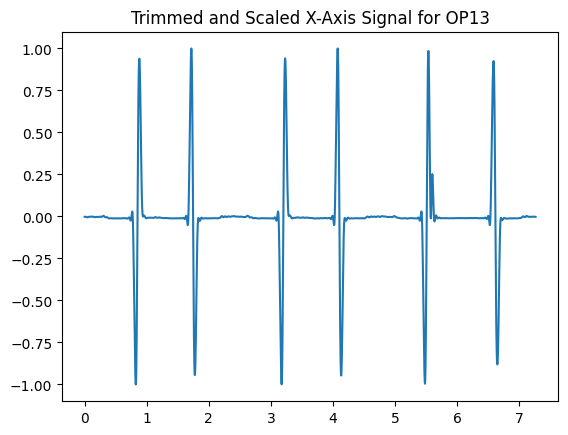

In [ ]:
## Now we want to trim based on second chunk

trimmed_indices_op13 = np.arange(start = (peaks_indices_op13[1] + peaks_indices_op13[2])//2, # between 1st and 2nd
                            stop = (peaks_indices_op13[10] + peaks_indices_op13[11])//2)  # right bound of 8th peak


# Trim the signal based on the selected indices
trimmed_signal_op13 = filtered_op13[trimmed_indices_op13]

# Rescale signal
trimmed_scaled_op13 = scaler.fit_transform(trimmed_signal_op13.reshape(-1, 1))

plt.plot(np.arange(len(trimmed_signal_op13))/2000, trimmed_scaled_op13)
plt.title('Trimmed and Scaled X-Axis Signal for OP13')

### Globalization of Processing

The conditions used to parse each signal were:

| Operation | LPF | PROM TH | PEAK RANGE | STEP TYPE |
| :-------: | :-: | :-----: | :--------: | :-------: |
| OP00 | 1.5 | 400 | 3-7 | Step Drill |
| OP01 | 10 | 1000 | 12-24 | Step Drill |
| OP02 | 10 | 1000 | 0-8 | Drill |
| OP03 | 3 | 150 | 2-23 | Step Drill |
| OP04 | 2 | 500 | 1-3 | Step Drill |
| OP05 | 20 | 1500 | 3-6 | Step Drill |
| OP06 | 7 | 1000 | 6-11 | Step Drill |
| OP09 | 2 | 400 | 1-5 | Straight Flute |
| OP13 | 20 | 1000 | 1-10 | T-Slot Cutter |

In [ ]:
## Get xx samples of each operation, clean all, then pass to NMF function


# I have M01 OPs 0-3 good data, need other machines and bad data
m02_op0_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP00',
                                                             labels[0]),
                                                'good')

m03_op0_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP00',
                                                             labels[0]),
                                                'good')


m02_op1_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP01',
                                                             labels[0]),
                                                'good')

m03_op1_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP01',
                                                             labels[0]),
                                                'good')

m02_op2_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP02',
                                                             labels[0]),
                                                'good')

m03_op2_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP02',
                                                             labels[0]),
                                                'good')

m02_op3_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP03',
                                                             labels[0]),
                                                'good')

m03_op3_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP03',
                                                             labels[0]),
                                                'good')

loading files from /content/CNC_Machining/data/M02/OP00/good... 
loading files from /content/CNC_Machining/data/M03/OP00/good... 
loading files from /content/CNC_Machining/data/M02/OP01/good... 
loading files from /content/CNC_Machining/data/M03/OP01/good... 
loading files from /content/CNC_Machining/data/M02/OP02/good... 
loading files from /content/CNC_Machining/data/M03/OP02/good... 
loading files from /content/CNC_Machining/data/M02/OP03/good... 
loading files from /content/CNC_Machining/data/M03/OP03/good... 


In [ ]:
## Get next batch of files

m02_op4_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP04',
                                                             labels[0]),
                                                'good')

m03_op4_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP04',
                                                             labels[0]),
                                                'good')


m02_op5_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP05',
                                                             labels[0]),
                                                'good')

m03_op5_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP05',
                                                             labels[0]),
                                                'good')

m02_op6_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP06',
                                                             labels[0]),
                                                'good')

m03_op6_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP06',
                                                             labels[0]),
                                                'good')

m02_op9_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP09',
                                                             labels[0]),
                                                'good')

m03_op9_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP09',
                                                             labels[0]),
                                                'good')

m02_op13_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[1],
                                                             'OP13',
                                                             labels[0]),
                                                'good')

m03_op13_good_array, _ = load_tool_research_data(os.path.join(s_dir,
                                                             machines[2],
                                                             'OP13',
                                                             labels[0]),
                                                'good')

loading files from /content/CNC_Machining/data/M02/OP04/good... 
loading files from /content/CNC_Machining/data/M03/OP04/good... 
loading files from /content/CNC_Machining/data/M02/OP05/good... 
loading files from /content/CNC_Machining/data/M03/OP05/good... 
loading files from /content/CNC_Machining/data/M02/OP06/good... 
loading files from /content/CNC_Machining/data/M03/OP06/good... 
loading files from /content/CNC_Machining/data/M02/OP09/good... 
loading files from /content/CNC_Machining/data/M03/OP09/good... 
loading files from /content/CNC_Machining/data/M02/OP13/good... 
loading files from /content/CNC_Machining/data/M03/OP13/good... 


In [ ]:
m01_op0_good_array[0]

array([[   -9.,     9., -1011.],
       [  -21.,    19., -1011.],
       [  -15.,    23., -1020.],
       ...,
       [  -13.,    33., -1015.],
       [  -13.,    27., -1016.],
       [  -31.,    25., -1020.]])

In [ ]:
## Create a list of arrays with each x-axis signal

## OP00
all_x_op0_good = []
all_x_op0_good.extend([arr[:, 0] for arr in m01_op0_good_array])
all_x_op0_good.extend([arr[:, 0] for arr in m02_op0_good_array])
all_x_op0_good.extend([arr[:, 0] for arr in m03_op0_good_array])


## OP01
all_x_op1_good = []
all_x_op1_good.extend([arr[:, 0] for arr in m01_op1_good_array])
all_x_op1_good.extend([arr[:, 0] for arr in m02_op1_good_array])
all_x_op1_good.extend([arr[:, 0] for arr in m03_op1_good_array])


## OP02
all_x_op2_good = []
all_x_op2_good.extend([arr[:, 0] for arr in m01_op2_good_array])
all_x_op2_good.extend([arr[:, 0] for arr in m02_op2_good_array])
all_x_op2_good.extend([arr[:, 0] for arr in m03_op2_good_array])


## OP03
all_x_op3_good = []
all_x_op3_good.extend([arr[:, 0] for arr in m01_op3_good_array])
all_x_op3_good.extend([arr[:, 0] for arr in m02_op3_good_array])
all_x_op3_good.extend([arr[:, 0] for arr in m03_op3_good_array])


## OP04
all_x_op4_good = []
all_x_op4_good.extend([arr[:, 0] for arr in m01_op4_good_array])
all_x_op4_good.extend([arr[:, 0] for arr in m02_op4_good_array])
all_x_op4_good.extend([arr[:, 0] for arr in m03_op4_good_array])


## OP05
all_x_op5_good = []
all_x_op5_good.extend([arr[:, 0] for arr in m01_op5_good_array])
all_x_op5_good.extend([arr[:, 0] for arr in m02_op5_good_array])
all_x_op5_good.extend([arr[:, 0] for arr in m03_op5_good_array])


## OP06
all_x_op6_good = []
all_x_op6_good.extend([arr[:, 0] for arr in m01_op6_good_array])
all_x_op6_good.extend([arr[:, 0] for arr in m02_op6_good_array])
all_x_op6_good.extend([arr[:, 0] for arr in m03_op6_good_array])


## OP09
all_x_op9_good = []
all_x_op9_good.extend([arr[:, 0] for arr in m01_op9_good_array])
all_x_op9_good.extend([arr[:, 0] for arr in m02_op9_good_array])
all_x_op9_good.extend([arr[:, 0] for arr in m03_op9_good_array])


## OP13
all_x_op13_good = []
all_x_op13_good.extend([arr[:, 0] for arr in m01_op13_good_array])
all_x_op13_good.extend([arr[:, 0] for arr in m02_op13_good_array])
all_x_op13_good.extend([arr[:, 0] for arr in m03_op13_good_array])


In [ ]:
## Apply processing techniques to each signal in lists

lpfs = [1.5, 10, 10, 3, 2, 20, 7, 2, 20]
proms = [400, 1000, 1000, 150, 500, 1500, 1000, 400, 1000]
first_peak_idx = [3, 12, 0, 2, 1, 3, 6, 1, 1]
last_peak_idx = [7, 24, 8, 23, 3, 6, 11, 5, 10]

op_lists = [all_x_op0_good, all_x_op1_good, all_x_op2_good, all_x_op3_good,
            all_x_op4_good, all_x_op5_good, all_x_op6_good, all_x_op9_good,
            all_x_op13_good]

trans_signals = [[],[],[],[],[],[],[],[],[]]

for i in range(len(op_lists)):
#for i in range(1):
  for arr in op_lists[i]:
    ## Apply low pass filter to array
    filtered_arr = lowpass(data = arr, freq_max = lpfs[i])

    ## Filter by peak prominence
    current_peak_indices, _ = signal.find_peaks(x = filtered_arr,
                                              prominence = proms[i])

    ## Get peak prominences
    current_peak_proms = signal.peak_prominences(filtered_arr, current_peak_indices)

    ## Filter to peaks in predefined range
    trimmed_indices = np.arange(start = (current_peak_indices[first_peak_idx[i]] +
                                         current_peak_indices[first_peak_idx[i]+1])//2,
                            stop = (current_peak_indices[last_peak_idx[i]] +
                                         current_peak_indices[last_peak_idx[i]+1])//2)


    ## Trim the signal based on the selected indices
    trimmed_signal = filtered_arr[trimmed_indices]

    ## Rescale signal
    trimmed_scaled = scaler.fit_transform(trimmed_signal.reshape(-1, 1))

    ## Append to result array
    trans_signals[i].append(trimmed_scaled)




Text(0.5, 1.0, 'Test of Globalized Cleaning for OP03')

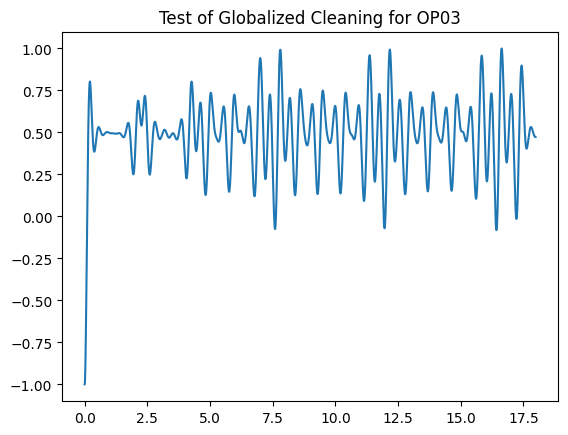

In [ ]:
## Check result

plt.plot(np.arange(len(trans_signals[3][52]))/2000, trans_signals[3][52])
plt.title('Test of Globalized Cleaning for OP03')

## I think that looks pretty good!

In [ ]:
## I also want to look at the lengths of each array by operation

# op0_lens = []
# op0_lens.append([len(arr) for arr in all_x_op0_good])

# op1_lens = []
# op1_lens.append([len(arr) for arr in all_x_op1_good])

# op2_lens = []
# op2_lens.append([len(arr) for arr in all_x_op2_good])

# op3_lens = []
# op3_lens.append([len(arr) for arr in all_x_op3_good])

# plt.hist(op0_lens, color = 'blue')
# plt.hist(op1_lens, color = 'green')
# plt.hist(op2_lens, color = 'red')
# plt.hist(op3_lens, color = 'purple')
# plt.title('Length of Trimmed Sequences by Operation')

Because all of the lengths are not equal within an operation, I will pad each sample to the longest length with zeros, then perform Fast Fourier Transform on the resulting signals.

I will apply the same logic across operations, so that I can pass all signals to an ndarray and perform PCA to reduce the dimensionality.

In [ ]:
### FFT on each operation

# op0_ffts = []
# op0_fftfreqs = []


# for arr in all_x_op0_good:
#   n = len(arr)
#   current_fft = fft.fft(arr)
#   current_freqs = fft.fftfreq(n, 1/2000)
#   op0_ffts.append(current_fft[1:n//2])
#   op0_fftfreqs.append(current_freqs[1:n//2])
#   plt.plot(current_freqs[1:n//2], np.abs(current_fft[1:n//2]))


In [ ]:
# for arr in all_x_op1_good:
#   n = len(arr)
#   current_fft = fft.fft(arr)
#   current_freqs = fft.fftfreq(n, 1/2000)
#   # op0_ffts.append(current_fft[1:n//2])
#   # op0_fftfreqs.append(current_freqs[1:n//2])
#   plt.plot(current_freqs[1:n//2], np.abs(current_fft[1:n//2]))

### FFT

Based on these two examples, I will pad each sample to the max length, then perform FFT and save the real components.

In [ ]:
# a= np.array([1,2,3])
# b = np.zeros(4)

# np.concatenate([a,b])

In [ ]:
# np.ravel(trans_signals[0][0]).shape

In [ ]:
# Initialize with list for each operation
fft_signals = [[],[],[],[],[],[],[],[],[]]


## Get length of max signal for padding
max_lengths = []
for i in range(len(trans_signals)):
  max_lengths.append(max(len(signal) for signal in trans_signals[i]))

max_len = np.max(max_lengths)

for i in range(len(trans_signals)):
  for arr in trans_signals[i]:

    ## Pad array to max length
    pad_sig = np.concatenate([np.ravel(arr), np.zeros(max_len - len(arr))])

    ## Compute FFT on padded signal
    fft_arr = fft.fft(pad_sig)

    ## Trim to first half and get abs value
    fft_signals[i].append(np.abs(fft_arr[1:max_len//2]))


### PCA and Clustering

In [ ]:
print(len(fft_signals))
print(len(fft_signals[0]))
#print(fft_signals[0].shape)
print(len(fft_signals[0][0]))
print(fft_signals[0][0].shape)


## How many samples are in each operation?

for lst in fft_signals:
  print(len(lst))

9
83
76710
(76710,)
83
136
148
68
105
114
84
113
142


In [ ]:
### Create a labels list for everything

# Need to filter out labels that contain unselected OPs
# data_labels = [k for k in good_datalabel if 'OP00' in k]
# data_labels.extend([k for k in good_datalabel if 'OP01' in k])
# data_labels.extend([k for k in good_datalabel if 'OP02' in k])
# data_labels.extend([k for k in good_datalabel if 'OP03' in k])
# data_labels.extend([k for k in good_datalabel if 'OP04' in k])
# data_labels.extend([k for k in good_datalabel if 'OP05' in k])
# data_labels.extend([k for k in good_datalabel if 'OP06' in k])
# data_labels.extend([k for k in good_datalabel if 'OP09' in k])
# data_labels.extend([k for k in good_datalabel if 'OP13' in k])

In [ ]:
op_labels = ['OP00' for k in good_datalabel if 'OP00' in k]
op_labels.extend(['OP01' for k in good_datalabel if 'OP01' in k])
op_labels.extend(['OP02' for k in good_datalabel if 'OP02' in k])
op_labels.extend(['OP03' for k in good_datalabel if 'OP03' in k])
op_labels.extend(['OP04' for k in good_datalabel if 'OP04' in k])
op_labels.extend(['OP05' for k in good_datalabel if 'OP05' in k])
op_labels.extend(['OP06' for k in good_datalabel if 'OP06' in k])
op_labels.extend(['OP09' for k in good_datalabel if 'OP09' in k])
op_labels.extend(['OP13' for k in good_datalabel if 'OP13' in k])

In [ ]:
## Flatten list of arrays:
fft_array = np.zeros(shape = (993,76710))
i = 0

for sig_grp in fft_signals:
    for sig in sig_grp:
      fft_array[i] = sig
      i += 1


#fft_array = np.asarray(fft_array, dtype = object)

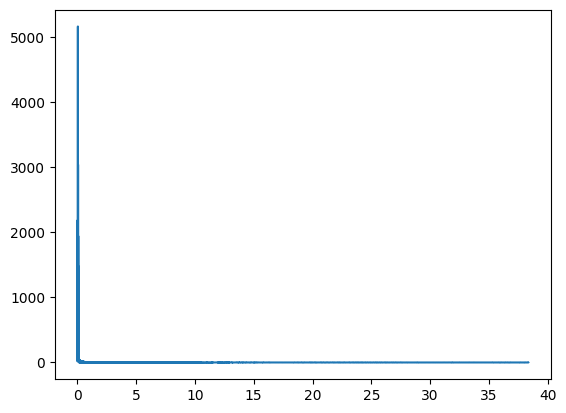

In [ ]:
plt.plot(np.arange(76710)/2000, fft_array[532])

In [ ]:
## Now actually do PCA!

# try extracting the first 5 principal components
pca = PCA(n_components = 5, random_state = 42, n_oversamples = 20)

pca_sig = pca.fit_transform(fft_array)




In [ ]:
## transform labels so that I can plot results by operation

#pca_sig[:,0]
# plt.scatter(pca_sig[:,0], pca_sig[:,1])

<Axes: >

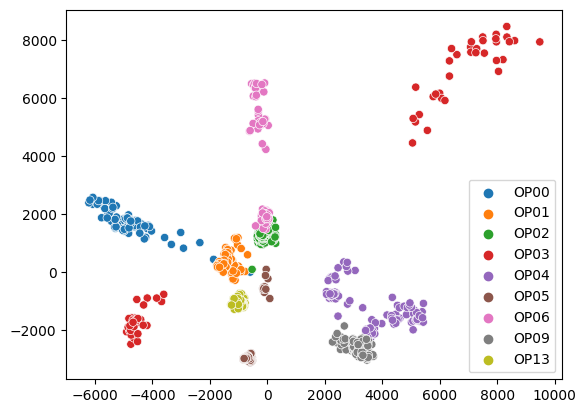

In [ ]:
sns.scatterplot(x = pca_sig[:,2], y = pca_sig[:,3], hue = op_labels)

From the plot above, we can see that the first two principal axes don't completely separate the 9 operations, though some are clearly more different than others, like OP03 and OP00.

Next, I am going to try NMF on the FFT array, separating into 9 components. I will compare this to the separation from PCA and see which is better.

In [ ]:
## There are a lot of hyperparameters in NMF, so I am going to start with the default ones and then tune

nmf = NMF(n_components = 9, random_state = 42)

W = nmf.fit_transform(fft_array)

H = nmf.components_

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
print(W.shape, H.shape)

(993, 9) (9, 76710)


In [ ]:
np.argmax(W[0:5,:], axis = -1)

array([0, 8, 8, 0, 0])

In [ ]:
nmf_pred = np.argmax(W, axis = -1)

In [ ]:
np.bincount(nmf_pred)

## Based upon some classes having 0 members, I am going to increase the number of iterations
## I will also try using 'nndsvdar' as the init param
  ## (NNDSVD with zeros filled with small random values
   ## (generally faster, less accurate alternative to NNDSVDa for when sparsity is not desired))

array([ 99, 525, 155,   0,   0,   0, 190,   0,  24])

In [ ]:
nmf2 = NMF(n_components = 9, random_state = 42, max_iter = 500, init = 'nndsvdar')

W2 = nmf2.fit_transform(fft_array)

H2 = nmf2.components_

In [ ]:
nmf2.n_iter_

142

In [ ]:
print(np.bincount(np.argmax(W2, axis = -1)))

## We avoided the timeout error and have elements in every bucket, but 474 in one is too many

## Try NNDSVD because we did pad zeros to the arrays

[ 25 150  34 157  34  29  61 474  29]


In [ ]:
nmf3 = NMF(n_components = 9, random_state = 42, max_iter = 500, init = 'nndsvd')

W3 = nmf3.fit_transform(fft_array)

H3 = nmf3.components_

In [ ]:
print(np.bincount(np.argmax(W3, axis = -1)))
print(nmf3.n_iter_)

[ 25 150  34 157  34  29  61 474  29]
162


In [ ]:
# Try regularization term
nmf4 = NMF(n_components = 9, random_state = 42, max_iter = 500,
           init = 'nndsvd', alpha_W = 0.2)

W4 = nmf4.fit_transform(fft_array)

H4 = nmf4.components_

print(np.bincount(np.argmax(W4, axis = -1)))
print(nmf4.n_iter_)

[ 27 149  34 157  34  29  61 475  27]
231


In [ ]:
## What happens when I do Kmeans on top 5 principal components?

## encode labels
encoder = LabelEncoder()

op_labels_enc = encoder.fit_transform(op_labels)

## Need to split test and train
x_train, x_test, y_train, y_test = train_test_split(pca_sig,
                                                    op_labels_enc,
                                                    test_size = 0.3,
                                                    random_state = 42)

kmeans_mod = KMeans(n_clusters = 9, random_state = 42)

sig_kmeans = kmeans_mod.fit_transform(x_train)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
np.bincount(kmeans_mod.labels_)

array([152, 208,  29,  40,  24, 128,  14,  74,  26])

In [ ]:
print(confusion_matrix(y_train, kmeans_mod.labels_))

## The kmeans labels are not necessarily in same order as labels


[[  0   0   0  40   0   0  14   0   0]
 [  0 102   0   0   0   1   0   0   0]
 [  0   0   0   0   0  94   0   0   0]
 [  0   0  29   0  24   0   0   0   0]
 [ 66   0   0   0   0   0   0   0   0]
 [  0   9   0   0   0   0   0  74   0]
 [  0   0   0   0   0  33   0   0  26]
 [ 86   0   0   0   0   0   0   0   0]
 [  0  97   0   0   0   0   0   0   0]]


In [ ]:
## SVC Classifier

classifier = SVC(kernel = 'rbf', class_weight = 'balanced', max_iter = 500,
                 random_state = 42).fit(x_train, y_train)

train_pred_svc = classifier.predict(x_train)

In [ ]:
print(np.bincount(train_pred_svc))

print(confusion_matrix(y_train, train_pred_svc))
print(accuracy_score(y_train, train_pred_svc))

[ 54 102  95  53  66  74  59  86 106]
[[ 54   0   0   0   0   0   0   0   0]
 [  0 102   1   0   0   0   0   0   0]
 [  0   0  94   0   0   0   0   0   0]
 [  0   0   0  53   0   0   0   0   0]
 [  0   0   0   0  66   0   0   0   0]
 [  0   0   0   0   0  74   0   0   9]
 [  0   0   0   0   0   0  59   0   0]
 [  0   0   0   0   0   0   0  86   0]
 [  0   0   0   0   0   0   0   0  97]]
0.9856115107913669


In [ ]:
test_pred_svc = classifier.predict(x_test)

print(confusion_matrix(y_test, test_pred_svc))
print(accuracy_score(y_test, test_pred_svc))

## Wow!!

[[29  0  0  0  0  0  0  0  0]
 [ 0 33  0  0  0  0  0  0  0]
 [ 0  0 54  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0]
 [ 0  0  1  0  0 25  0  0  5]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0 45]]
0.9798657718120806


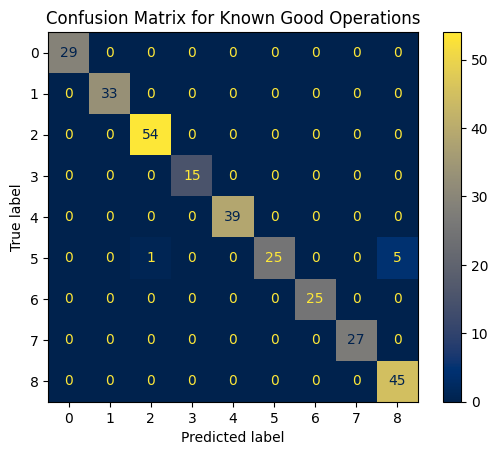

In [ ]:
cm = confusion_matrix(y_test, test_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
disp.plot(cmap = 'cividis')

plt.title('Confusion Matrix for Known Good Operations')
#plt.subtitle('Expectation is Results Off-Diagonal')

plt.show()

In [ ]:
# def label_permute_compare(ytdf,yp,n=9):

#     # get all permutations of label orders:
#     perms = itertools.permutations(np.unique(yp))
#     # init best accuracy measure
#     best_acc = 0
#     best_perm = ''

#     ## change labels to numeric in order to compare to model output
#     # label_list = ytdf.iloc[:,0]
#     # label_names = ytdf.iloc[:,0].unique()
#     label_list = ytdf
#     label_names = np.unique(ytdf)

#     for perm in perms:
#         order_to_label = {}

#         for i in range(len(perm)):
#             order_to_label[label_names[i]] = perm[i]

#         def translate_item(item):
#             return order_to_label.get(item, item)

#         translated_list = list(map(translate_item, label_list))

#         conf = confusion_matrix(y_true = translated_list, y_pred = yp)
#         correct = 0
#         for i in range(conf.shape[0]):
#             correct += conf[i,i]

#         acc = correct / len(label_list)

#         if acc > best_acc:
#             best_acc = acc
#             best_perm = perm

#     return (best_perm, best_acc)

In [ ]:
# label_permute_compare(y_train, kmeans_mod.labels_)

## 65% accuracy, can we do better?

### Bad Data

Now, how does classifier perform on bad data?

In [ ]:
## Need to filter bad data labels to not include OPs
## 7, 8, 10, 11, 12, 14

# import re

# def Filter(string, substr):
#     return [str for str in string if
#              any(sub in str for sub in substr)]

# # Driver code
# string = ['city1', 'class5', 'room2', 'city2']
# substr = ['class', 'city']

operations = ['OP00', 'OP01', 'OP02', 'OP03', 'OP04', 'OP05',
              'OP06', 'OP09', 'OP13']

# bad_datalbl = [lbl for lbl in bad_datalabel if any(s in lbl for s in operations)]

bad_datalbl = []
bad_datalst = []

for i in range(len(bad_datalabel)):
  if any(s in bad_datalabel[i] for s in operations):
    bad_datalbl.append(bad_datalabel[i])
    bad_datalst.append(bad_datalist[i])


In [ ]:
bad_datalbl

['M01_Aug_2019_OP01_000_bad',
 'M01_Feb_2019_OP01_000_bad',
 'M01_Feb_2019_OP02_000_bad',
 'M01_Aug_2019_OP03_000_bad',
 'M01_Aug_2019_OP04_000_bad',
 'M01_Feb_2019_OP04_000_bad',
 'M01_Aug_2019_OP05_000_bad',
 'M01_Feb_2019_OP05_000_bad',
 'M01_Feb_2019_OP05_001_bad',
 'M01_Feb_2021_OP05_000_bad',
 'M01_Aug_2019_OP06_000_bad',
 'M01_Aug_2021_OP06_000_bad',
 'M01_Aug_2021_OP06_001_bad',
 'M01_Aug_2021_OP06_002_bad',
 'M01_Aug_2019_OP09_000_bad',
 'M02_Feb_2021_OP00_000_bad',
 'M02_Aug_2019_OP01_000_bad',
 'M02_Feb_2019_OP01_000_bad',
 'M02_Feb_2019_OP01_001_bad',
 'M02_Feb_2019_OP02_000_bad',
 'M02_Feb_2019_OP02_001_bad',
 'M02_Feb_2021_OP03_000_bad',
 'M02_Aug_2019_OP04_000_bad',
 'M02_Feb_2019_OP04_000_bad',
 'M02_Feb_2019_OP04_002_bad',
 'M02_Feb_2019_OP05_000_bad',
 'M02_Feb_2019_OP05_001_bad',
 'M03_Aug_2019_OP01_000_bad',
 'M03_Feb_2021_OP01_000_bad',
 'M03_Feb_2021_OP02_000_bad',
 'M03_Aug_2019_OP04_000_bad',
 'M03_Feb_2021_OP04_000_bad']

In [ ]:
bad_datalst[5].shape

print(bad_datalbl[5])

M01_Feb_2019_OP04_000_bad


In [ ]:
## I need to load in bad data - 32 traces, no OP13

## I already have all the labels for which operation and the arrays ready

## Need to apply signal cleaning based on operation


lpfs = [1.5, 10, 10, 3, 2, 20, 7, 2, 20]
proms = [400, 1000, 1000, 150, 500, 1500, 1000, 400, 1000]
first_peak_idx = [3, 12, 0, 2, 1, 3, 6, 1, 1]
last_peak_idx = [7, 24, 8, 23, 3, 6, 11, 5, 10]

# op_lists = [all_x_op0_good, all_x_op1_good, all_x_op2_good, all_x_op3_good,
#             all_x_op4_good, all_x_op5_good, all_x_op6_good, all_x_op9_good,
#             all_x_op13_good]

# remove one elt, no op13
#trans_signals_bad = [[],[],[],[],[],[],[],[]]

trans_signals_bad = []


for i in range(len(bad_datalbl)):
  for j in range(len(operations)):
    if operations[j] in bad_datalbl[i]:
      #for arr in op_lists[i]:
        ## Apply low pass filter to array
      #print(f'i = {i}, j = {j}, op = {operations[j]}, label = {bad_datalbl[i]}')
      filtered_arr = lowpass(data = bad_datalst[i][:,0], freq_max = lpfs[j])

      ## Filter by peak prominence
      current_peak_indices, _ = signal.find_peaks(x = filtered_arr,
                                                prominence = proms[j])

      ## Get peak prominences
      current_peak_proms = signal.peak_prominences(filtered_arr, current_peak_indices)

      ## Filter to peaks in predefined range
      if len(current_peak_indices) >= last_peak_idx[j+1]:
        trimmed_indices = np.arange(start = (current_peak_indices[first_peak_idx[j]] +
                                            current_peak_indices[first_peak_idx[j]+1])//2,
                                stop = (current_peak_indices[last_peak_idx[j]] +
                                            current_peak_indices[last_peak_idx[j]+1])//2)


        ## Trim the signal based on the selected indices
        trimmed_signal = filtered_arr[trimmed_indices]
      else:
        trimmed_signal = filtered_arr

      ## Rescale signal
      trimmed_scaled = scaler.fit_transform(trimmed_signal.reshape(-1, 1))

      ## Append to result array
      trans_signals_bad.append(trimmed_scaled)

In [ ]:
fft_signals_bad = []

## Signals need to be the same length as good

## Get length of max signal for padding
# max_lengths = []
# for i in range(len(trans_signals)):
#   max_lengths.append(max(len(signal) for signal in trans_signals[i]))

#max_len_bad = np.max([len(signal) for signal in trans_signals_bad])

for i in range(len(trans_signals_bad)):

  if len(trans_signals_bad[i]) <= max_len:
    ## Pad array to max length
    pad_sig = np.concatenate([np.ravel(trans_signals_bad[i]),
                              np.zeros(max_len - len(trans_signals_bad[i]))])

  else:
    pad_sig = np.ravel(trans_signals_bad[i])[:max_len]

  ## Compute FFT on padded signal
  fft_arr = fft.fft(pad_sig)

  ## Trim to first half and get abs value
  fft_signals_bad.append(np.abs(fft_arr[1:max_len//2]))

In [ ]:
op_labels_bad = ['OP00' for k in bad_datalbl if 'OP00' in k]
op_labels_bad.extend(['OP01' for k in bad_datalbl if 'OP01' in k])
op_labels_bad.extend(['OP02' for k in bad_datalbl if 'OP02' in k])
op_labels_bad.extend(['OP03' for k in bad_datalbl if 'OP03' in k])
op_labels_bad.extend(['OP04' for k in bad_datalbl if 'OP04' in k])
op_labels_bad.extend(['OP05' for k in bad_datalbl if 'OP05' in k])
op_labels_bad.extend(['OP06' for k in bad_datalbl if 'OP06' in k])
op_labels_bad.extend(['OP09' for k in bad_datalbl if 'OP09' in k])
op_labels_bad.extend(['OP13' for k in bad_datalbl if 'OP13' in k])


fft_array_bad = np.asarray(fft_signals_bad)

In [ ]:
## Fit PCA on bad values


pca_sig_bad = pca.transform(fft_array_bad)

op_labels_enc_bad = encoder.transform(op_labels_bad)




Text(0, 0.5, 'Fourth Principal Component')

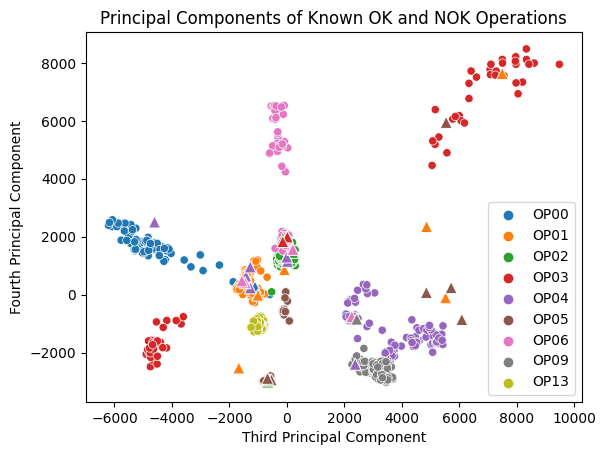

In [ ]:
## Show plot of bad values against good:
sns.scatterplot(x = pca_sig[:,2], y = pca_sig[:,3], hue = op_labels)

sns.scatterplot(x = pca_sig_bad[:,2], y = pca_sig_bad[:,3], hue = op_labels_bad,
                marker="^", legend = False, s = 75)
plt.title('Principal Components of Known OK and NOK Operations')
plt.xlabel('Third Principal Component')
plt.ylabel('Fourth Principal Component')

A lot of times the marker colors do not match the good colors in that area. Curious to see how they will do in the confusion matrix

In [ ]:
## SVC Classifier

# classifier = SVC(kernel = 'rbf', class_weight = 'balanced', max_iter = 500,
#                  random_state = 42).fit(x_train, y_train)

bad_pred_svc = classifier.predict(pca_sig_bad)

In [ ]:
print(confusion_matrix(op_labels_enc_bad, bad_pred_svc))
print(accuracy_score(op_labels_enc_bad, bad_pred_svc))

[[0 1 0 0 0 0 0 0]
 [0 1 1 2 1 2 0 0]
 [0 0 0 0 0 2 2 0]
 [0 0 0 0 0 0 2 0]
 [1 3 2 0 0 0 0 1]
 [0 0 0 1 3 2 0 0]
 [0 2 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 0]]
0.09375


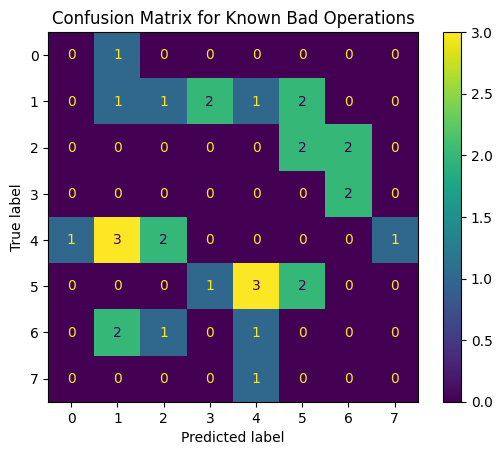

In [ ]:
cm_bad = confusion_matrix(op_labels_enc_bad, bad_pred_svc)
disp_bad = ConfusionMatrixDisplay(confusion_matrix=cm_bad,
                               display_labels=np.unique(op_labels_enc_bad))
disp_bad.plot()

plt.title('Confusion Matrix for Known Bad Operations')
#plt.subtitle('Expectation is Results Off-Diagonal')

plt.show()